# Task 1: ECG Heartbeat Categorization 

Segmented and Preprocessed ECG Signals for Heartbeat Classification

1) Download the dataset from the ECG Heartbeat Categorization Dataset:
https://www.kaggle.com/datasets/shayanfazeli/heartbeat
2) Unzip the archive.zip file
3) Rename the folder archive as ecg_dataset and place it in the root of the git repository

References: 
ECG Heartbeat Classification: A Deep Transferable Representation: https://arxiv.org/pdf/1805.00794.pdf

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
#import lightgbm as lgb

# The PTB Diagnostic ECG Database
Number of Samples: 14552
Number of Categories: 2
Sampling Frequency: 125Hz
Data Source: Physionet's PTB Diagnostic Database
ECG lead II re-sampled to the sampling frequency of 125Hz as the input (from ECG Heartbeat Classification: A Deep Transferable Representation)
Remark: All the samples are cropped, downsampled and padded with zeroes if necessary to the fixed dimension of 188.
The final element of each row denotes the class to which that example belongs.

The shape of the normal dataframe is :  (4046, 188)
Class :  0.0
The shape of the abnormal dataframe is :  (10506, 188)
Class :  1.0
The last time value is :  1488.0


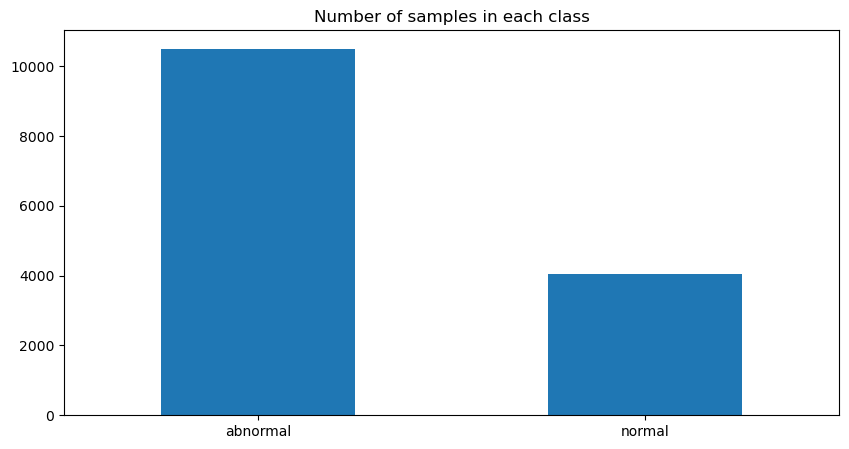

In [11]:
#df_ptbd_normal = pd.read_csv("../ecg_dataset/ptbdb_normal.csv", header = None)
#df_ptbd_abnormal = pd.read_csv("../ecg_dataset/ptbdb_abnormal.csv", header = None)

df_ptbd_normal = pd.read_csv('C:/Users/Justin/Documents/LLNL/Data/Task1/ecg_dataset/ptbdb_normal.csv', header=None)
df_ptbd_abnormal = pd.read_csv('C:/Users/Justin/Documents/LLNL/Data/Task1/ecg_dataset/ptbdb_abnormal.csv', header=None)

# print shapes of the dataframes
print("The shape of the normal dataframe is : ", df_ptbd_normal.shape)
# print one example of the last column
print("Class : ", df_ptbd_normal.iloc[:, -1][0])
print("The shape of the abnormal dataframe is : ", df_ptbd_abnormal.shape)
# print one example of the last column
print("Class : ", df_ptbd_abnormal.iloc[:, -1][0])

# classes are 0 (normal) and 1 (abnormal)
classes_names = {0 : "normal",
                 1 : "abnormal"}

# get the number of columns in the dataframe
# the last column is the label/class
num_cols = df_ptbd_normal.shape[1] - 1
# the signal was resampled at frequency of 125Hz as the input
# compute the time vector
time = np.arange(0, num_cols) / 125
# convert to milliseconds
time = time * 1000
# print last time value
print("The last time value is : ", time[-1])

# for the first "num_cols" and the time steps as column names
df_ptbd_normal.columns = list(time) + ["label"]
df_ptbd_abnormal.columns = list(time) + ["label"]

# concatenate the two dataframes
df_ptbd = pd.concat([df_ptbd_normal, df_ptbd_abnormal], axis = 0)

# count the number of samples in each class and plot a bar chart
# change the class names to "normal" and "abnormal"
# count the number of samples in each class
counts = df_ptbd["label"].value_counts()
# substitute the class names: 0.0 -> normal, 1.0 -> abnormal
counts.index = counts.index.map(classes_names)
# create a figure
plt.figure(figsize = (10, 5))
# plot a bar chart
counts.plot(kind = "bar")
# plot xticks in angle
plt.xticks(rotation = 0)
plt.title("Number of samples in each class")
plt.show()

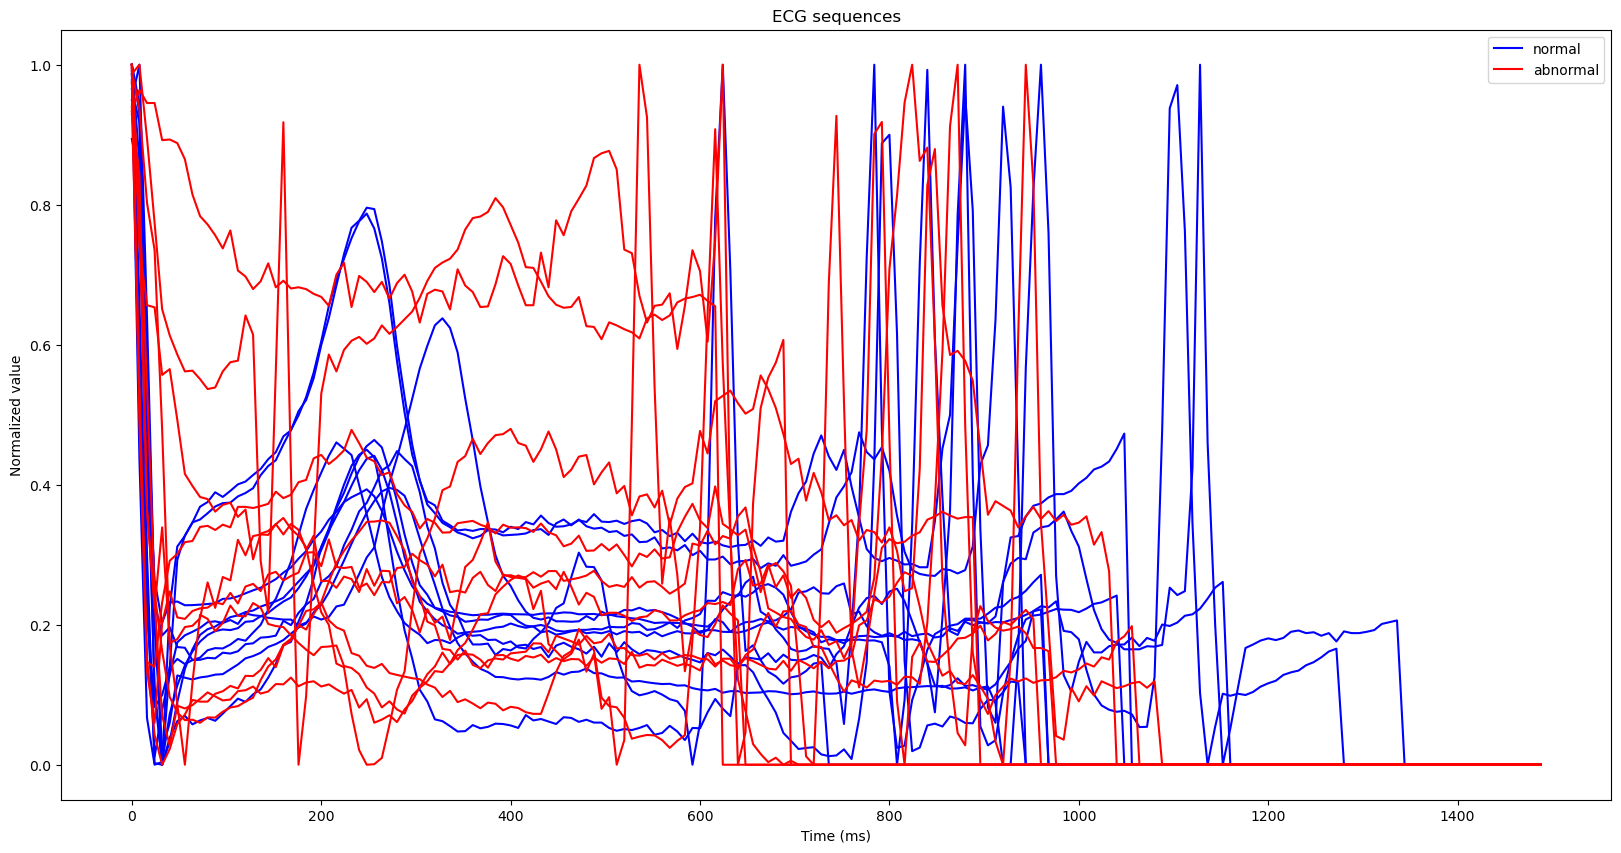

In [12]:
# plot a a row of the dataframe
# select 10 random sequences with class 0 (normal) and 10 with class 1 (abnormal)
df_ptbd_normal = df_ptbd[df_ptbd["label"] == 0].sample(10)
df_ptbd_abnormal = df_ptbd[df_ptbd["label"] == 1].sample(10)

# create a figure
plt.figure(figsize = (20, 10))
# plot againts the column names (time)
# plot the normal sequences
for i in range(df_ptbd_normal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1], color = "blue", label = "normal")
    else:
        plt.plot(df_ptbd_normal.columns[:-1], df_ptbd_normal.iloc[i, :-1],color = "blue")
# plot the abnormal sequences
for i in range(df_ptbd_abnormal.shape[0]):
    if i == 0:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red", label = "abnormal")
    else:
        plt.plot(df_ptbd_abnormal.columns[:-1], df_ptbd_abnormal.iloc[i, :-1], color = "red")
# create a legend for the plot, blue for normal and red for abnormal
plt.legend()
# set the title
plt.title("ECG sequences")
# y lable is "Normalized value"
plt.ylabel("Normalized value")
# x label is "Time (ms)"
plt.xlabel("Time (ms)")
# show the plot
plt.show()
# close
plt.close()

In [20]:
# Convert o numpy array 
X = df_ptbd.to_numpy()
XX = X[:,:-1]
Y = X[:,-1]
print("Input data dimensions:", XX.shape)
print("Input label dimensions:", Y.shape)

Input data dimensions: (14552, 187)
Input label dimensions: (14552,)


# Random Forest with grid search 

In [ ]:
# Random forest with K-CV and grid search 
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(XX, Y, test_size=0.3, stratify=y, random_state=42)

# Create Random Forest classifier
rf = RandomForestClassifier()

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees [100, 200, 300]
    'max_depth': [None, 2],  # Maximum depth of each tree [None, 5, 10],
    'min_samples_split': [2, 4],  # Minimum number of samples required to split an internal node [2, 5, 10],
    'min_samples_leaf': [1, 2],  # Minimum number of samples required to be at a leaf node [1, 2, 4]
    'max_features': ['sqrt', 'log2']  # Number of features to consider when looking for the best split ['sqrt', 'log2'] 
}

# Perform grid search with stratified cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Get the best model and its performance
best_model = grid_search.best_estimator_
best_score = grid_search.best_score_

# Evaluate the best model on the test set
test_score = best_model.score(X_test, y_test)

# Print the best hyperparameters and scores
print("Best Hyperparameters:", grid_search.best_params_)
print("Best Cross-Validation Accuracy:", best_score)
print("Test Accuracy:", test_score)

# Best Hyperparameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, ... 
# 'min_samples_split': 2, 'n_estimators': 200}
